This script is for the processing and visualization of Worldview Satellite data and WARM buoy/sidekick ("sk") data from the BORG lab group at Old Dominion University.  Also included are comparable historical data from the 1998 SHEBA ice camp campaign (data available at EOL data archive: https://data.eol.ucar.edu/).  WARM buoy and satellite data are from the Chukchi Sea, summer of 2018.  

NOTE: I am still working on processing the 2.5 m temperature and salinity data from SHEBA.  The way it is formatted is a huge pain in the ass.

In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#read in data
#I like keeping different processed levels of data and data from different platforms in separate CSV's for organizational purposes
buoy7_daily = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/Project/Data/buoy7_L4.csv')
buoy8_daily = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/Project/Data/buoy8_L4.csv')
buoy7_hourly = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/Project/Data/buoy7_L3.csv')
buoy8_hourly = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/Project/Data/buoy8_L3.csv')
sk3 = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/Project/Data/SK3_L3.csv')
sk4 = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/Project/Data/SK4_L3.csv')
wv = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/Project/Data/WV.csv')
sheba = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/Project/Data/sheba.csv')

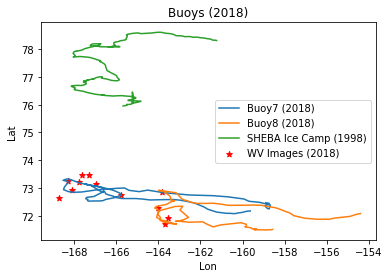

In [28]:
#location (sk locations not plotted, as they are co-located with the buoys)
fig1 = plt.figure()
plt.plot(buoy7_daily.GPSLongitude[34:125],buoy7_daily.GPSLatitude[34:125])
plt.plot(buoy8_daily.GPSLongitude[32:123],buoy8_daily.GPSLatitude[32:123])
plt.scatter(wv.Lon,wv.Lat, color='r', marker='*')
plt.plot(sheba.lon[4918:7124],sheba.lat[4918:7124])
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend(['Buoy7 (2018)','Buoy8 (2018)','SHEBA Ice Camp (1998)','WV Images (2018)'])
plt.title('Buoys (2018)')
plt.show()

Note that SHEBA ice camp was located several degrees north of the buoys.  This will become apparent in the data shown.  Buoys drifted from East to West, while the ice camp drifted from South to North.  Lat/Lon data shown are only for May-1 through July-31 of the respective year.  Worldview ("WV") satellite images are denoted by the red stars.

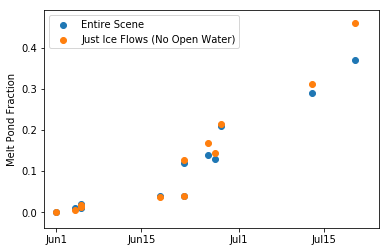

In [26]:
#plot melt pond data
plt.scatter(wv.Date_Julian,wv.DMP)
plt.scatter(wv.Date_Julian,wv.DMP_NoWater)
plt.legend(['Entire Scene','Just Ice Flows (No Open Water)'])
plt.xticks([43252,43266,43282,43296], ['Jun1','Jun15','Jul1','Jul15'])
plt.xlim(43250,43305)
plt.ylabel('Melt Pond Fraction')
plt.show()

Melt pond fraction from Worldview Satellite imagery, to be used as the target variable in machine learning.  Data points show pond fractions for entire images (accounting for large sections of open water, blue), as well as for just the ice flows (open water not included, orange).

In [4]:
#resample hourly metrics to daily means and sums

#set indices
buoy7_hourly = buoy7_hourly.set_index('DataDateTime')
buoy8_hourly = buoy8_hourly.set_index('DataDateTime')
sk3 = sk3.set_index('DataDateTime')
sk4 = sk4.set_index('DataDateTime')
#convert to pandas friendly date format
buoy7_hourly.index = pd.to_datetime(buoy7_hourly.index)
buoy8_hourly.index = pd.to_datetime(buoy8_hourly.index)
sk3.index = pd.to_datetime(sk3.index)
sk4.index = pd.to_datetime(sk4.index)
#convert PAR/s to PAR/hr
b7_par_hr = buoy7_hourly*3600
b8_par_hr = buoy8_hourly*3600
sk3_par_hr = sk3*3600
sk4_par_hr = sk4*3600
#convert PAR/hr to PAR/d
DailySum_b7 = b7_par_hr.resample('D').sum()
DailySum_b8 = b8_par_hr.resample('D').sum()
DailySum_sk3 = sk3_par_hr.resample('D').sum()
DailySum_sk4 = sk4_par_hr.resample('D').sum()
DailyMean_b7 = buoy7_hourly.resample('D').mean()
DailyMean_b8 = buoy8_hourly.resample('D').mean()

#Now for SHEBA data

#set indices
sheba = sheba.set_index('datetime')
#convert to pandas friendly date format
sheba.index = pd.to_datetime(sheba.index)
#convert PAR/s to PAR/hr
sheba_par_hr = sheba*3600
#sheba_par_hr = sheba_par_hr[sheba_par_hr['swd_umol'].notna()]
#convert PAR/hr to PAR/d
DailySum_sheba = sheba_par_hr.resample('D').sum()
DailyMean_sheba = sheba.resample('D').mean()
print(DailySum_sheba.columns)
#DailySum_sheba.index = DailySum_sheba.index.strftime('%m-%d')
#print(DailySum_sheba.index)

Index(['julian_date', 'jd', 'lat', 'lon', 'press', 'Tsfc', 'Tice', 'snwdpthi',
       'icethck', 'cf_immcr', 'lwp_immcr', 'iwp_immcr', 'swd', 'swd_umol',
       'swu', 'lwd', 'lwu', 'lwnet', 'swnet', 'alb', 'swtransm',
       'swtransm_umol', 'radnet', 'hsmed', 'usmed', 'hlmed', 'hturb',
       'cflxmed', 'fatm', 'fnet', 't2', 't10', 'q2', 'q10', 'rh2', 'rh10',
       'ws2', 'ws10', 'wd2', 'wd10'],
      dtype='object')


The above cell creates new dataframes that convert hourly data values to daily values.  When working with PAR (Photosynthetically Available Radiation), the original data values are presented in units of umol photon/m^2/s.  Values are multiplied by 3600 to convert to umol photon/m^2/hr, assuming a constant irradiance value for the entirety of that hour.  These values are then summed for each solar day, to get umol photon/m^2/day.  Additional dataframes are resampled to obtain daily means, used for temp and salinity data.

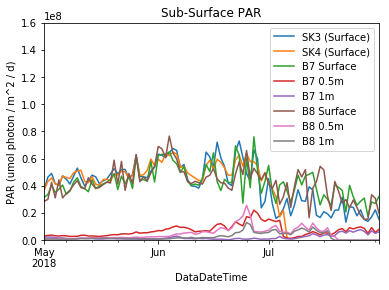

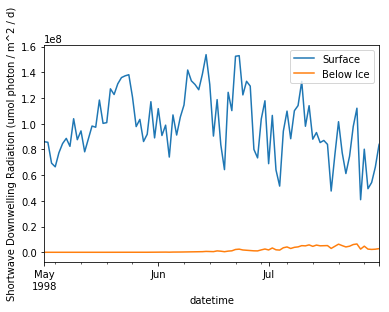

In [25]:
#surface PAR
fig, ax = plt.subplots(1, 1)
DailySum_sk3.plot(y=["LI_192_0"], ax=ax, title='PAR')
DailySum_sk4.plot(y=["LI_192_0"], ax=ax)
DailySum_b7.plot(y=["LI_192_0","LI_192_1","LI_192_2"], ax=ax, title='Sub-Surface PAR')
DailySum_b8.plot(y=["LI_192_0","LI_192_1","LI_192_2"], ax=ax)
ax.set_xlim(pd.Timestamp('2018-05-01'), pd.Timestamp('2018-07-31'))
ax.set_ylim(0,160000000)
ax.set_ylabel('PAR (umol photon / m^2 / d)')
ax.legend(['SK3 (Surface)','SK4 (Surface)','B7 Surface','B7 0.5m','B7 1m','B8 Surface','B8 0.5m','B8 1m'], loc='upper right')
plt.show()

#downwelling shortwave radiation
ax1=DailySum_sheba.plot(y=["swd_umol","swtransm_umol"])
ax1.set_xlim(pd.Timestamp('1998-05-01'), pd.Timestamp('1998-07-31'))
ax1.set_ylabel('Shortwave Downwelling Radiation (umol photon / m^2 / d)')
ax1.legend(['Surface','Below Ice'], loc='upper right')
plt.show()

The above figure shows daily integrated PAR values.  SK4 failed in early July, as shown by its rapidly decreasing values (orange).  For buoy data (top) surface irradiance values are significantly higher than 0.5m(in ice) and 1m(bottom of ice) values, as is expected from the severe attenuation of light by ice and snow.  An increase in 0.5m and 1m irradiance is shown in late June and early July, as the ice begins to melt and pond.  SHEBA data (bottom) shows surface values around twice as high as the buoy data, possibly because SHEBA was located further north, thus the sun stayed at higher solar angles for longer periods during the day.  Conversely, there is less light below the ice at SHEBA, likely due to thicker ice ("below ice" values were not specified at a given depth, as the ice thickness was always changing, but was generally more than 1m).

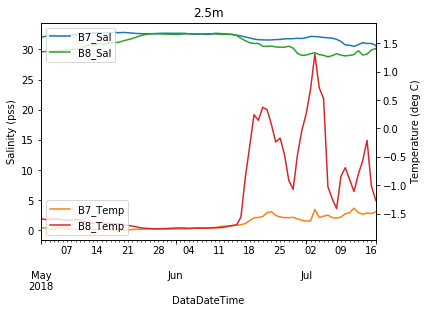

In [15]:
#plot temp and sal at 2.5m
fig, ax = plt.subplots(1, 1)
ax0=DailyMean_b7.plot(y=["B7_Sal"], ax=ax, title='2.5m')
ax1=DailyMean_b7.plot(y=["B7_Temp"], ax=ax, secondary_y=True)
ax0=DailyMean_b8.plot(y=["B8_Sal"], ax=ax)
ax1=DailyMean_b8.plot(y=["B8_Temp"], ax=ax, secondary_y=True)
ax.right_ax.set_ylabel('Temperature (deg C)')
ax.set_ylabel('Salinity (pss)')
ax.set_xlim(pd.Timestamp('2018-05-01'), pd.Timestamp('2018-07-17'))
ax0.legend(loc='upper left')
ax1.legend(loc='lower left')
plt.show()

Buoy temperature and salinity data from 2.5m.  Spikes in temperature reported by buoy 8 are likely a result of warm melt pond water draining into the upper water column (evidenced by a freshening event at the same time).

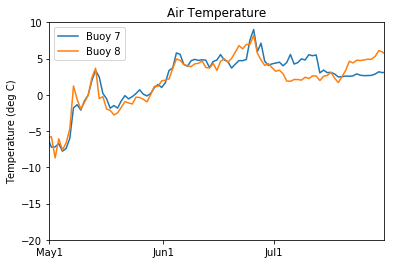

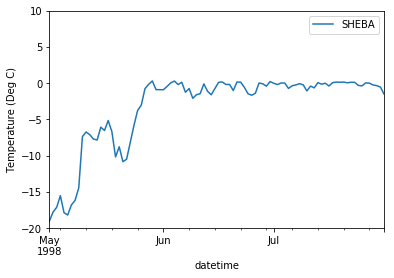

In [12]:
#now read in corrected AT data from buoys
air_temp_corr_b7 = buoy7_daily.SST + 3.94
air_temp_corr_b8 = buoy8_daily.SST + 3.14
plt.plot(buoy7_daily.dts_Solar,air_temp_corr_b7)
plt.plot(buoy8_daily.dts_Solar,air_temp_corr_b8)
plt.legend(['Buoy 7','Buoy 8'])
plt.xticks([43221,43252,43282], ['May1','Jun1','Jul1'])
plt.xlim(43221,43312)
plt.ylabel('Temperature (deg C)')
plt.title('Air Temperature')
plt.ylim(-20,10)
plt.show()

#air temperature
ax2 = DailyMean_sheba.plot(y=["Tsfc"])
ax2.set_xlim(pd.Timestamp('1998-05-01'), pd.Timestamp('1998-07-31'))
ax2.set_ylabel('Temperature (Deg C)')
ax2.legend(['SHEBA'])
ax2.set_ylim(-20,10)
plt.show()

Air temperature from buoys (top) and SHEBA (bottom).  SHEBA is clearly ~5-10 degrees colder than the buoys, likely due to it being stationed further north.